# Simple California Demo 2.0



This notebook shows how to use build a hierarchical clustering of the input features and use it to explain a single instance. This is a good way to explain a single instance when the number of input features is large.
When given a balanced partition tree PartitionExplainer has $O(M^2)$ runtime, where $M$ is the number of input features. This is much better than the $O(2^M)$ runtime of KernelExplainer.

In [1]:
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp
import scipy.cluster
from xgboost import XGBRegressor

import shap

seed = 2023
np.random.seed(seed)

/home/b00p/anaconda3/envs/shap/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Train a model

In [2]:
X, y = shap.datasets.california()
model = XGBRegressor(n_estimators=100, subsample=0.3)
model.fit(X, y)

instance = X[0:1]
references = X[1:100]

## Compute a hierarchical clustering of the input features

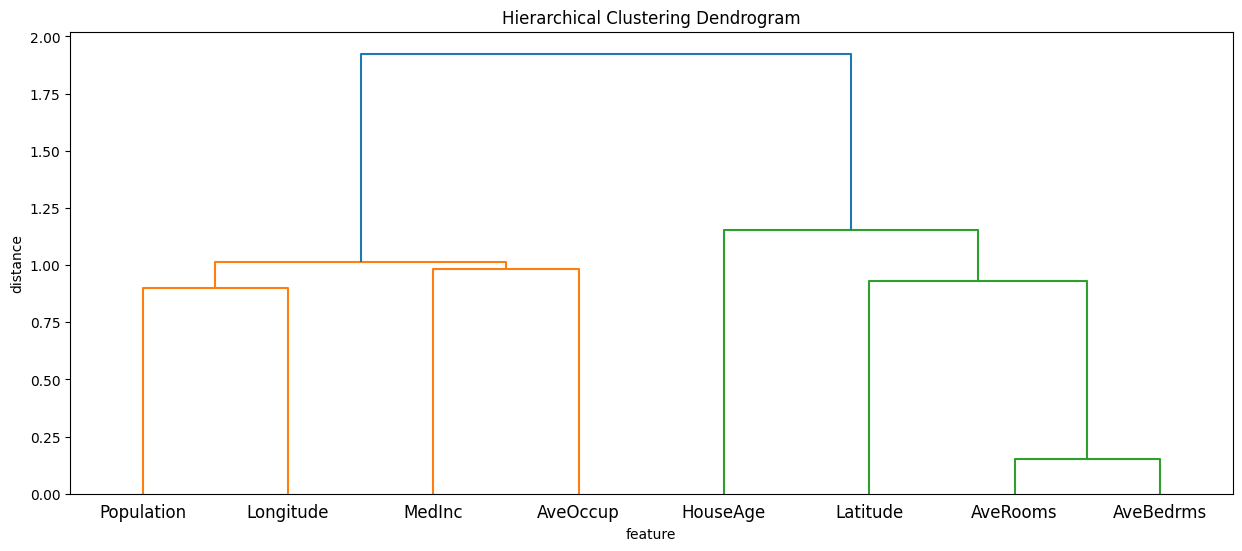

In [3]:
partition_tree = shap.utils.partition_tree(X)
plt.figure(figsize=(15, 6))
sp.cluster.hierarchy.dendrogram(partition_tree, labels=X.columns)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
plt.show()

## Explain the instance

To demonstrate the new behaviour and check if the new method works by passing hierarchies corresponding to the exact and binary partition methods and a third I just made up. 

In [4]:
def build_partition_hierarchy(linkage, labels):
    n = len(labels)
    cluster_dict = {}

    # Initialize leaves
    for i in range(n):
        cluster_dict[i] = labels[i]

    # Build clusters
    for i, row in enumerate(linkage):
        idx1 = int(row[0])
        idx2 = int(row[1])
        cluster_id = n + i  # New cluster index

        # Create cluster names
        if idx1 < n:
            left = cluster_dict[idx1]
        else:
            left = f"cluster_{idx1}"

        if idx2 < n:
            right = cluster_dict[idx2]
        else:
            right = f"cluster_{idx2}"

        # Create the new cluster
        cluster_dict[cluster_id] = {left: cluster_dict[idx1], right: cluster_dict[idx2]}

    # The root cluster
    root_cluster_id = n + len(linkage) - 1
    return {f"cluster_{root_cluster_id}": cluster_dict[root_cluster_id]}

In [5]:
partition_hierarchy_b = build_partition_hierarchy(partition_tree, X.columns)

In [6]:
# hierarchy created by the original binary partition method
# partition_hierarchy_b = {
#     "cluster_14": {
#         "cluster_12": {
#             "cluster_9": {"Population": "Population", "Longitude": "Longitude"},
#             "cluster_11": {"MedInc": "MedInc", "AveOccup": "AveOccup"},
#         },
#         "cluster_13": {
#             "HouseAge": "HouseAge",
#             "cluster_10": {
#                 "Latitude": "Latitude",
#                 "cluster_8": {"AveRooms": "AveRooms", "AveBedrms": "AveBedrms"},
#             },
#         },
#     }
# }

# exact partition hierarchy flat
partition_hierarchy_f = {
    "AveOccup": "AveOccup",
    "MedInc": "MedInc",
    "Longitude": "Longitude",
    "Population": "Population",
    "HouseAge": "HouseAge",
    "Latitude": "Latitude",
    "AveBedrms": "AveBedrms",
    "AveRooms": "AveRooms",
}

# custom partition
partition_hierarchy_nb = {
    "HouseCharacteristics": {
        "AveBedrms": "AveBedrms",
        "AveRooms": "AveRooms",
        "AveOccup": "AveOccup",
        "HouseAge": "HouseAge",
    },
    "Area": {
        "Location": {"Latitude": "Latitude", "Longitude": "Longitude"},
        "Neighbours": {"MedInc": "MedInc", "Population": "Population"},
    },
}
# custom partition
partition_hierarchy_nb2 = {
    "Activity": {
        "MedInc": "MedInc",
        "AveOccup": "AveOccup",
        "Population": "Population",
    },
    "Material": {
        "AveBedrms": "AveBedrms",
        "AveRooms": "AveRooms",
        "HouseAge": "HouseAge",
    },
    "Location": {"Latitude": "Latitude", "Longitude": "Longitude"},
}

In [7]:
# Exact Shap values
start_time = time.time()
exact_explainer = shap.ExactExplainer(model.predict, X)
exact_shap_values = exact_explainer(references)
print(f"Exact Shap values computed in {time.time() - start_time:.2f} seconds")

# Tree Shap values
start_time = time.time()
tree_explainer = shap.TreeExplainer(model, X)
tree_shap_values = tree_explainer(references)
print(f"Tree Shap values computed in {time.time() - start_time:.2f} seconds")

# Old binary winter values
start_time = time.time()
masker_explainer = shap.PartitionExplainer(model.predict, X)
binary_winter_values = masker_explainer(references)
print(f"Binary Winter values computed in {time.time() - start_time:.2f} seconds")

start_time = time.time()
# build a masker from partition tree
masker = shap.maskers.Partition(X, clustering=partition_tree)
masker_explainer = shap.PartitionExplainer(model.predict, masker)
masker_winter_values = masker_explainer(references)
print(
    f"Binary Winter values specifying the tree computed in {time.time() - start_time:.2f} seconds"
)


# Recreating the old binary winter values
start_time = time.time()
partition_masker = shap.maskers.Partition(X)
partition_explainer = shap.PartitionExplainer(
    model.predict, partition_masker, partition_tree=partition_hierarchy_b
)
partition_winter_values_b = partition_explainer(references)
print(
    f"Partition Winter values (binary hierarchy) computed in {time.time() - start_time:.2f} seconds"
)

# Shapley values corresponding to flat hierarchy
start_time = time.time()
partition_explainer_f = shap.PartitionExplainer(
    model.predict, partition_masker, partition_tree=partition_hierarchy_f
)
partition_winter_values_f = partition_explainer_f(references)
print(
    f"Partition Winter values (flat hierarchy) computed in {time.time() - start_time:.2f} seconds"
)

# Shapley values for non-binary hierarchy
start_time = time.time()
partition_explainer_nb = shap.PartitionExplainer(
    model.predict, partition_masker, partition_tree=partition_hierarchy_nb
)
partition_winter_values_nb = partition_explainer_nb(references)
print(
    f"Partition Winter values (non-binary hierarchy) computed in {time.time() - start_time:.2f} seconds"
)

# Shapley values for another non-binary hierarchy
start_time = time.time()
partition_explainer_nb2 = shap.PartitionExplainer(
    model.predict, partition_masker, partition_tree=partition_hierarchy_nb2
)
partition_winter_values_nb2 = partition_explainer_nb2(references)
print(
    f"Partition Winter values (non-binary hierarchy 2) computed in {time.time() - start_time:.2f} seconds"
)

Exact Shap values computed in 3.94 seconds
Tree Shap values computed in 0.34 seconds
Binary Winter values computed in 3.50 seconds
Binary Winter values specifying the tree computed in 1.69 seconds
Partition Winter values (binary hierarchy) computed in 3.84 seconds


PartitionExplainer explainer: 100it [00:21,  2.40it/s]                          


Partition Winter values (flat hierarchy) computed in 21.22 seconds
Partition Winter values (non-binary hierarchy) computed in 4.54 seconds
Partition Winter values (non-binary hierarchy 2) computed in 5.02 seconds


In [8]:
model.predict(instance)  # check if the explanation methods partition the space properly

array([4.1875715], dtype=float32)

## Compare to Tree SHAP

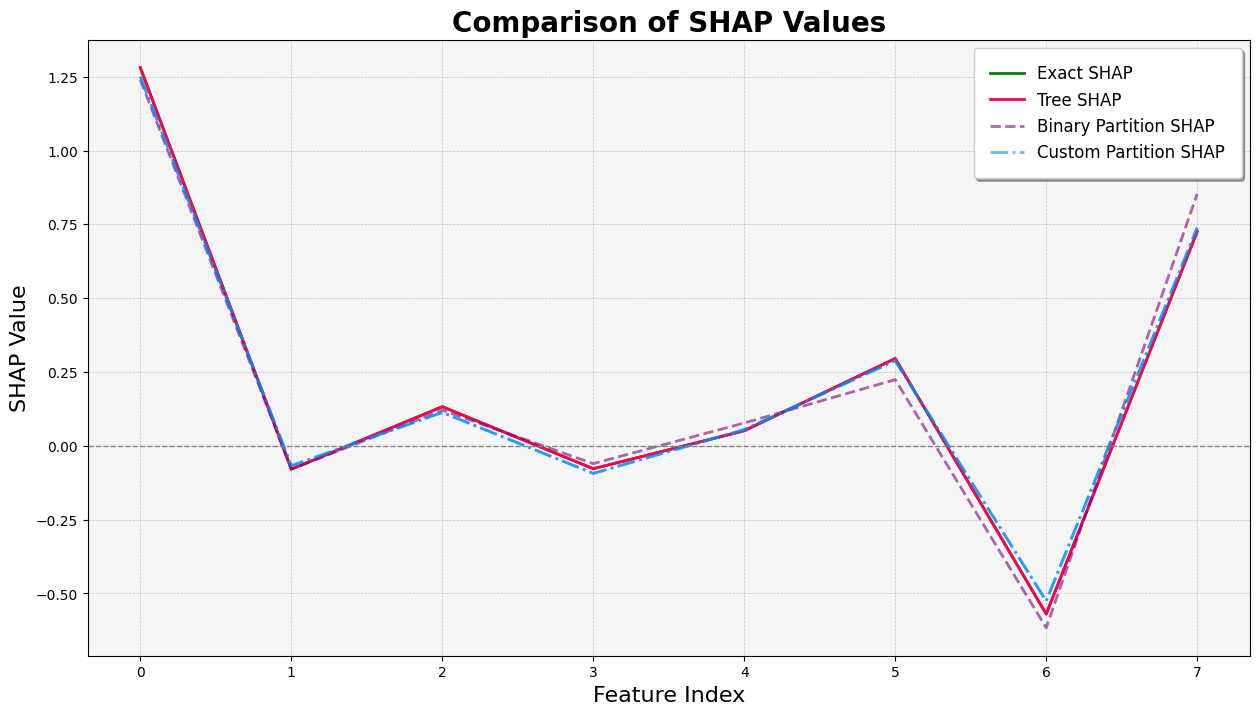

In [9]:
import matplotlib.pyplot as plt
from skimage.color import lab2rgb, lch2lab


def lch2rgb(x):
    return lab2rgb(lch2lab([[x]]))[0][0]


blue_lch = [54.0, 70.0, 4.6588]
red_lch = [54.0, 90.0, 0.35470565 + 2 * np.pi]

plt.figure(figsize=(15, 8))

# Plot the SHAP values with enhanced visibility
plt.plot(
    exact_shap_values.values[0],
    linestyle="-",
    linewidth=2,
    label="Exact SHAP",
    color="green",
)
plt.plot(
    tree_shap_values.values[0],
    linestyle="-",
    linewidth=2,
    label="Tree SHAP",
    color=lch2rgb(red_lch),
    alpha=1,
)
plt.plot(
    binary_winter_values.values[0],
    linestyle="--",
    linewidth=2,
    label="Binary Partition SHAP",
    color="purple",
    alpha=0.6,
)
plt.plot(
    partition_winter_values_b.values[0],
    linestyle="-.",
    linewidth=2,
    label="Custom Partition SHAP",
    color=lch2rgb(blue_lch),
    alpha=0.6,
)
plt.plot(
    partition_winter_values_b.values[0],
    linestyle="-.",
    linewidth=2,
    label="Custom Partition SHAP",
    color=lch2rgb(blue_lch),
    alpha=0.6,
)


# Adding title and labels with increased font sizes
plt.title("Comparison of SHAP Values", fontsize=20, fontweight="bold")
plt.xlabel("Feature Index", fontsize=16)
plt.ylabel("SHAP Value", fontsize=16)

# Customizing the legend for better readability
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper right",
    fontsize=12,
    frameon=True,
    fancybox=True,
    shadow=True,
    borderpad=1,
)

# Adding a grid for better readability
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Adding a light grey background
plt.gca().set_facecolor("whitesmoke")

# Adding a horizontal line at y=0 for reference
plt.axhline(0, color="grey", linestyle="--", linewidth=1)

# Display the plot
plt.show()

In [14]:
import math
import queue  # multi-producer, multi-consumer queues
import time  # time execution
from itertools import chain, combinations, product

import numpy as np  # numpy base
from numba import njit  # just in time compiler
from tqdm.auto import tqdm  # progress bar

from shap import Explanation, links  # shap modules
from shap.explainers._explainer import Explainer
from shap.models import Model
from shap.utils import MaskedModel, OpChain, make_masks, safe_isinstance


class PartitionExplainer_dev(Explainer):
    def __init__(
        self,
        model,
        masker,
        *,
        output_names=None,
        link=links.identity,
        linearize_link=True,
        feature_names=None,
        partition_tree=None,
        **call_args,
    ):
        super().__init__(
            model,
            masker,
            link=link,
            linearize_link=linearize_link,
            algorithm="partition",
            output_names=output_names,
            feature_names=feature_names,
        )

        self.input_shape = (
            masker.shape[1:]
            if hasattr(masker, "shape") and not callable(masker.shape)
            else None
        )
        if not safe_isinstance(self.model, "shap.models.Model"):
            self.model = Model(self.model)

        self.expected_value = None
        self._curr_base_value = None

        if self.input_shape is not None and len(self.input_shape) > 1:
            self._reshaped_model = lambda x: self.model(
                x.reshape(x.shape[0], *self.input_shape)
            )
        else:
            self._reshaped_model = self.model

        self.partition_tree = partition_tree

        if not callable(self.masker.clustering):
            self._clustering = self.masker.clustering
            self._mask_matrix = make_masks(self._clustering)

        if len(call_args) > 0:

            class PartitionExplainer(self.__class__):
                def __call__(
                    self,
                    *args,
                    max_evals=500,
                    fixed_context=None,
                    main_effects=False,
                    error_bounds=False,
                    batch_size="auto",
                    outputs=None,
                    silent=False,
                ):
                    return super().__call__(
                        *args,
                        max_evals=max_evals,
                        fixed_context=fixed_context,
                        main_effects=main_effects,
                        error_bounds=error_bounds,
                        batch_size=batch_size,
                        outputs=outputs,
                        silent=silent,
                    )

            PartitionExplainer.__call__.__doc__ = self.__class__.__call__.__doc__
            self.__class__ = PartitionExplainer
            for k, v in call_args.items():
                self.__call__.__kwdefaults__[k] = v

    def __call__(
        self,
        *args,
        max_evals=500,
        fixed_context=None,
        main_effects=False,
        error_bounds=False,
        batch_size="auto",
        outputs=None,
        silent=False,
    ):
        return super().__call__(
            *args,
            max_evals=max_evals,
            fixed_context=fixed_context,
            main_effects=main_effects,
            error_bounds=error_bounds,
            batch_size=batch_size,
            outputs=outputs,
            silent=silent,
        )

    def explain_row(
        self,
        *row_args,
        max_evals,
        main_effects,
        error_bounds,
        batch_size,
        outputs,
        silent,
        fixed_context="auto",
    ):
        if fixed_context == "auto":
            fixed_context = None
        elif fixed_context not in [0, 1, None]:
            raise ValueError(
                f"Unknown fixed_context value passed (must be 0, 1 or None): {fixed_context}"
            )

        fm = MaskedModel(
            self.model, self.masker, self.link, self.linearize_link, *row_args
        )
        M = len(fm)
        m00 = np.zeros(M, dtype=bool)
        if self._curr_base_value is None or not getattr(
            self.masker, "fixed_background", False
        ):
            self._curr_base_value = fm(m00.reshape(1, -1), zero_index=0)[0]
        f11 = fm(~m00.reshape(1, -1))[0]

        if self.partition_tree is not None:  # the current logic
            return self.explain_with_partition_tree(fm, self._curr_base_value, outputs)
        else:
            return self.explain_with_clustering(
                fm,
                self._curr_base_value,
                f11,
                max_evals,
                outputs,
                fixed_context,
                batch_size,
                silent,
                row_args,
            )

    def explain_with_clustering(
        self,
        fm,
        f00,
        f11,
        max_evals,
        outputs,
        fixed_context,
        batch_size,
        silent,
        row_args,
    ):
        if callable(self.masker.clustering):
            self._clustering = self.masker.clustering(*row_args)
            self._mask_matrix = make_masks(self._clustering)
        M = len(fm)
        # m00 = np.zeros(M, dtype=bool)
        if (
            hasattr(self._curr_base_value, "shape")
            and len(self._curr_base_value.shape) > 0
        ):
            if outputs is None:
                outputs = np.arange(len(self._curr_base_value))
            elif isinstance(outputs, OpChain):
                outputs = outputs.apply(Explanation(f11)).values

            out_shape = (2 * self._clustering.shape[0] + 1, len(outputs))
        else:
            out_shape = (2 * self._clustering.shape[0] + 1,)

        if max_evals == "auto":
            max_evals = 500

        self.values = np.zeros(out_shape)
        self.dvalues = np.zeros(out_shape)

        self.winter(
            fm,
            self._curr_base_value,
            f11,
            max_evals - 2,
            outputs,
            fixed_context,
            batch_size,
            silent,
        )
        self.values[:] = self.dvalues
        lower_credit(len(self.dvalues) - 1, 0, M, self.values, self._clustering)
        return {
            "values": self.values[:M].copy(),
            "expected_values": self._curr_base_value
            if outputs is None
            else self._curr_base_value[outputs],
            "mask_shapes": [s + out_shape[1:] for s in fm.mask_shapes],
            "main_effects": None,
            "hierarchical_values": self.dvalues.copy(),
            "clustering": self._clustering,
            "output_indices": outputs,
            "output_names": getattr(self.model, "output_names", None),
        }

    def explain_with_partition_tree(self, fm, f00, outputs):
        # Step 1: Generate all unique masks
        self.root = Node("Root")
        build_tree(self.partition_tree, self.root)
        self.combinations_list = generate_paths_and_combinations(self.root)
        # print("self.combinations",self.combinations_list)
        self.masks, self.keys = create_masks1(self.root, self.masker.feature_names)
        self.masks_dict = dict(zip(self.keys, self.masks))
        self.mask_permutations = create_combined_masks(
            self.combinations_list, self.masks_dict
        )
        # print("mask_permutations", self.mask_permutations, "\n")
        self.masks_list = [mask for _, mask, _ in self.mask_permutations]
        self.unique_masks_set = set(map(tuple, self.masks_list))
        self.unique_masks = [np.array(mask) for mask in self.unique_masks_set]

        # Step 2: Compute model results for all unique masks
        mask_results = {}
        for mask in self.unique_masks:
            result = fm(mask.reshape(1, -1))
            mask_results[tuple(mask)] = result

        # Step 3: Compute marginals for permutations
        shap_values = np.zeros(len(fm))
        last_key_to_off_indexes, last_key_to_on_indexes, weights = (
            map_combinations_to_unique_masks(self.mask_permutations, self.unique_masks)
        )

        feature_name_to_index = {
            name: idx for idx, name in enumerate(self.masker.feature_names)
        }
        # collected_weights = []
        # Step 4: Implement Owen values weighting
        for last_key in last_key_to_off_indexes:
            off_indexes = last_key_to_off_indexes[last_key]
            on_indexes = last_key_to_on_indexes[last_key]
            weight_list = weights[last_key]

            for off_index, on_index, weight in zip(
                off_indexes, on_indexes, weight_list
            ):
                # print(weight)
                off_result = mask_results[tuple(self.unique_masks[off_index])]
                on_result = mask_results[tuple(self.unique_masks[on_index])]
                # print(off_result)
                # print(on_result)
                # print("weight before calculation", weight) # this might be interesting to plot
                # collected_weights.append(weight)

                marginal_contribution = (on_result - off_result) * weight
                # print(marginal_contribution)
                shap_values[feature_name_to_index[last_key]] += (
                    marginal_contribution  # .item()
                )

        # Step 5: Return results
        return {
            "values": shap_values.copy(),
            "expected_values": f00,
            "mask_shapes": [s + () for s in fm.mask_shapes],
            "main_effects": None,
            "hierarchical_values": shap_values,
            "clustering": None,
            "output_indices": outputs,
            "output_names": getattr(self.model, "output_names", None),
        }

    def __str__(self):
        return "shap.explainers.PartitionExplainer()"

    def winter(
        self, fm, f00, f11, max_evals, output_indexes, fixed_context, batch_size, silent
    ):
        M = len(fm)
        m00 = np.zeros(M, dtype=bool)
        base_value = f00
        ind = len(self.dvalues) - 1

        if output_indexes is not None:
            f00 = f00[output_indexes]
            f11 = f11[output_indexes]

        q = queue.PriorityQueue()
        q.put((0, 0, (m00, f00, f11, ind, 1.0)))
        eval_count = 0
        total_evals = min(max_evals, (M - 1) * M)
        pbar = None
        start_time = time.time()
        while not q.empty():
            if eval_count >= max_evals:
                while not q.empty():
                    m00, f00, f11, ind, weight = q.get()[2]
                    self.dvalues[ind] += (f11 - f00) * weight
                break

            batch_args = []
            batch_masks = []

            while (
                not q.empty()
                and len(batch_masks) < batch_size
                and eval_count + len(batch_masks) < max_evals
            ):
                m00, f00, f11, ind, weight = q.get()[2]

                lind = int(self._clustering[ind - M, 0]) if ind >= M else -1
                rind = int(self._clustering[ind - M, 1]) if ind >= M else -1

                if ind < M:
                    distance = -1
                else:
                    if self._clustering.shape[1] >= 3:
                        distance = self._clustering[ind - M, 2]
                    else:
                        distance = 1

                if distance < 0:
                    # print(ind)
                    # print(weight)
                    self.dvalues[ind] += (f11 - f00) * weight
                    continue

                m10 = m00.copy()
                m10[:] += self._mask_matrix[lind, :]

                m01 = m00.copy()
                m01[:] += self._mask_matrix[rind, :]

                batch_args.append((m00, m10, m01, f00, f11, ind, lind, rind, weight))
                batch_masks.append(m10)
                batch_masks.append(m01)

            batch_masks = np.array(batch_masks)

            if len(batch_args) > 0:
                fout = fm(batch_masks)
                if output_indexes is not None:
                    fout = fout[:, output_indexes]

                eval_count += len(batch_masks)

                if pbar is None and time.time() - start_time > 5:
                    pbar = tqdm(total=total_evals, disable=silent, leave=False)
                    pbar.update(eval_count)
                if pbar is not None:
                    pbar.update(len(batch_masks))

            for i in range(len(batch_args)):
                m00, m10, m01, f00, f11, ind, lind, rind, weight = batch_args[i]

                f10 = fout[2 * i]
                f01 = fout[2 * i + 1]

                new_weight = weight
                if fixed_context is None:
                    new_weight /= 2

                if fixed_context is None or fixed_context == 0:
                    args = (m00, f00, f10, lind, new_weight)
                    q.put(
                        (
                            -np.max(np.abs(f10 - f00)) * new_weight,
                            np.random.randn(),
                            args,
                        )
                    )

                    args = (m00, f00, f01, rind, new_weight)
                    q.put(
                        (
                            -np.max(np.abs(f01 - f00)) * new_weight,
                            np.random.randn(),
                            args,
                        )
                    )

                if fixed_context is None or fixed_context == 1:
                    args = (m01, f01, f11, lind, new_weight)
                    q.put(
                        (
                            -np.max(np.abs(f11 - f01)) * new_weight,
                            np.random.randn(),
                            args,
                        )
                    )

                    args = (m10, f10, f11, rind, new_weight)
                    q.put(
                        (
                            -np.max(np.abs(f11 - f10)) * new_weight,
                            np.random.randn(),
                            args,
                        )
                    )

        if pbar is not None:
            pbar.close()

        self.last_eval_count = eval_count

        return output_indexes, base_value


@njit
def lower_credit(i, value, M, values, clustering):
    if i < M:
        values[i] += value
        return
    li = int(clustering[i - M, 0])
    ri = int(clustering[i - M, 1])
    group_size = int(clustering[i - M, 3])
    lsize = int(clustering[li - M, 3]) if li >= M else 1
    rsize = int(clustering[ri - M, 3]) if ri >= M else 1
    assert lsize + rsize == group_size
    values[i] += value
    lower_credit(li, values[i] * lsize / group_size, M, values, clustering)
    lower_credit(ri, values[i] * rsize / group_size, M, values, clustering)


class Node:
    def __init__(self, key):
        self.key = key
        self.child = []
        self.permutations = []  # this may not be the greatest idea??
        self.weights = []

    def __repr__(self):
        return f"({self.key}): {self.child} -> {self.permutations} \\ {self.weights}"


# This function is to encode the dictionary to our specific structure
def build_tree(d, root):
    if isinstance(d, dict):
        for key, value in d.items():
            node = Node(key)
            root.child.append(node)
            build_tree(value, node)
    elif isinstance(d, list):
        for item in d:
            node = Node(item)
            root.child.append(node)
    # get all the sibling permutations
    generate_permutations(root)


# generate all permutations of sibling nodes and assign it to the nodes
def generate_permutations(node):
    if not node.child:  # Leaf node
        node.permutations = []
        return

    children_keys = [child.key for child in node.child]
    node.permutations = {}

    for i, child in enumerate(node.child):
        excluded = children_keys[:i] + children_keys[i + 1 :]
        generate_permutations(child)

        # Generate all unique combinations of permutations for each child
        child.permutations = list(all_subsets(excluded))
        # print(len(children_keys))
        # print([len(permutation) for permutation in child.permutations])
        child.weights = [
            compute_weight(len(children_keys), len(permutation))
            for permutation in child.permutations
        ]
        # print(child.weights)


def compute_weight(total, selected):
    return 1 / (total * math.comb(total - 1, selected))


def all_subsets(iterable):
    return chain.from_iterable(
        combinations(iterable, n) for n in range(len(iterable) + 1)
    )


def get_all_leaf_values(node):
    leaves = []
    if not node.child:
        leaves.append(node.key)
    else:
        for child in node.child:
            leaves.extend(get_all_leaf_values(child))
    return leaves


def create_masks1(node, columns):
    masks = [np.zeros(len(columns), dtype=bool)]
    keys = [()]

    if not node.child:
        mask = columns == node.key
        masks.append(mask)
        keys.append(node.key)
    else:
        current_node_mask = columns.isin(get_all_leaf_values(node))
        masks.append(current_node_mask)
        keys.append(node.key)

        for subset in node.child:
            child_masks, child_keys = create_masks1(subset, columns)
            masks.extend(child_masks)
            keys.extend(child_keys)

    return masks, keys


def generate_paths_and_combinations(node):
    paths = []

    def dfs(current_node, current_path):
        current_path.append(
            (current_node.key, current_node.permutations, current_node.weights)
        )

        if not current_node.child:  # Leaf node
            paths.append(current_path[:])  # Make a copy of current_path
        else:
            for child in current_node.child:
                dfs(child, current_path)

        current_path.pop()  # Backtrack

    dfs(node, [])

    combinations_list = []
    # print("the paths",paths)

    for path in paths:
        filtered_path = [(key, perms, weight) for key, perms, weight in path if perms]
        # print("filtered_path", filtered_path, "\n")
        if filtered_path:
            node_keys, permutations, weights = zip(*filtered_path)
            path_combinations = list(product(*permutations))
            weight_combinations = list(product(*weights))
            # print("path combos", path_combinations, len(path_combinations))
            # print("the weight combs", weight_combinations, len(weight_combinations))
            weight_products = [
                np.prod(weight_tuple) for weight_tuple in weight_combinations
            ]
            # print(weight_products)

            last_key = node_keys[-1]
            for i, combination in enumerate(path_combinations):
                combinations_list.append((last_key, combination, weight_products[i]))

    return combinations_list


def combine_masks(masks):
    combined_mask = np.logical_or.reduce(masks)
    return combined_mask


def create_combined_masks(combinations, masks_dict):
    combined_masks = []
    for last_key, combination, weights in combinations:
        masks = []
        for keys in combination:
            if isinstance(keys, tuple) and not keys:
                continue
            for key in keys:
                if key in masks_dict:
                    masks.append(masks_dict[key])

        if masks:
            combined_mask = combine_masks(masks)
            combined_masks.append((last_key, combined_mask, weights))

            if last_key in masks_dict:
                combined_mask_with_last_key = combine_masks(
                    masks + [masks_dict[last_key]]
                )
                combined_masks.append((last_key, combined_mask_with_last_key, weights))
        else:
            combined_mask = np.zeros_like(list(masks_dict.values())[0])
            combined_masks.append((last_key, combined_mask, weights))

            if last_key in masks_dict:
                combined_mask_with_last_key = combine_masks(
                    [combined_mask, masks_dict[last_key]]
                )
                combined_masks.append((last_key, combined_mask_with_last_key, weights))
    return combined_masks


def map_combinations_to_unique_masks(combined_masks, unique_masks):
    unique_mask_index_map = {tuple(mask): idx for idx, mask in enumerate(unique_masks)}
    last_key_to_off_indexes = {}
    last_key_to_on_indexes = {}
    weights = {}

    for i, (last_key, combined_mask, weight) in enumerate(combined_masks):
        mask_tuple = tuple(combined_mask)
        unique_index = unique_mask_index_map[mask_tuple]

        if i % 2 == 0:  # Even index -> OFF value
            if last_key not in last_key_to_off_indexes:
                last_key_to_off_indexes[last_key] = []
                weights[last_key] = []
            last_key_to_off_indexes[last_key].append(unique_index)
            weights[last_key].append(weight)
        else:  # Odd index -> ON value
            if last_key not in last_key_to_on_indexes:
                last_key_to_on_indexes[last_key] = []
            last_key_to_on_indexes[last_key].append(unique_index)

    return last_key_to_off_indexes, last_key_to_on_indexes, weights


def create_partition_hierarchy(linkage_matrix, columns):
    def build_hierarchy(node, linkage_matrix, columns):
        if node < len(columns):
            return {columns[node]: columns[node]}
        else:
            left_child = int(linkage_matrix[node - len(columns), 0])
            right_child = int(linkage_matrix[node - len(columns), 1])
            left_subtree = build_hierarchy(left_child, linkage_matrix, columns)
            right_subtree = build_hierarchy(right_child, linkage_matrix, columns)
            return {f"cluster_{node}": {**left_subtree, **right_subtree}}

    root_node = len(linkage_matrix) + len(columns) - 1
    hierarchy = build_hierarchy(root_node, linkage_matrix, columns)
    return hierarchy[f"cluster_{root_node}"]

In [15]:
partition_explainer_f = PartitionExplainer_dev(
    model.predict, partition_masker, partition_tree=partition_hierarchy_f
)
partition_winter_values_f = partition_explainer_f(references)

/tmp/ipykernel_19349/2485948622.py:245: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  shap_values[feature_name_to_index[last_key]] += marginal_contribution #.item()
PartitionExplainer_dev explainer: 100it [00:23,  2.41it/s]                      


In [17]:
exact_shap_values[0]

.values =
array([ 1.28056324, -0.07918735,  0.13245386, -0.07768946,  0.05104823,
        0.29559353, -0.56975337,  0.72537109])

.base_values =
1.975365586578846

.data =
array([ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,  9.71880492e-01,
        2.40100000e+03,  2.10984183e+00,  3.78600000e+01, -1.22220000e+02])

In [18]:
partition_winter_values_f[0]

.values =
array([ 1.28056324, -0.07918735,  0.13245386, -0.07768946,  0.05104823,
        0.29559353, -0.56975337,  0.72537109])

.base_values =
1.975365586578846

.data =
array([ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,  9.71880492e-01,
        2.40100000e+03,  2.10984183e+00,  3.78600000e+01, -1.22220000e+02])

Partition SHAP values using a partition tree are nice estimation of SHAP values. The partition tree is a good way to reduce the number of input features and speed up the computation.

## Plots to explain the instance

In [ ]:
if np.allclose(partition_winter_values_f.values, exact_shap_values.values):
    print("Partition method can reproduce exact Shapley values")

if np.allclose(partition_winter_values_b.values, masker_winter_values.values):
    print("Partition method can reproduce the binary Winter values")

In [ ]:
# The exact Shap values
shap.plots.waterfall(exact_shap_values[0])

shap.plots.waterfall(tree_shap_values[0])

shap.plots.waterfall(partition_winter_values_f[0])  # This should match the previous


# Binary Winter values
shap.plots.waterfall(binary_winter_values[0])

# Binary Winter values specifying the partition_tree
shap.plots.waterfall(masker_winter_values[0])

# Partition Winter values (binary hierarchy but with the new method)
shap.plots.waterfall(partition_winter_values_b[0])  # This should match the previous


# Partition Winter values (non-binary hierarchy)
shap.plots.waterfall(partition_winter_values_nb[0])
# Partition Winter values (non-binary hierarchy)
shap.plots.waterfall(partition_winter_values_nb2[0])

In [ ]:
def add_nodes_edges(graph, parent_name, parent_dict):
    for key, value in parent_dict.items():
        if isinstance(value, dict):
            graph.add_node(key)
            graph.add_edge(parent_name, key)
            add_nodes_edges(graph, key, value)
        else:
            graph.add_node(value)
            graph.add_edge(parent_name, value)


def hierarchy_pos(G, root=None, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5):
    pos = _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    return pos


def _hierarchy_pos(
    G,
    root,
    width=1.0,
    vert_gap=0.2,
    vert_loc=0,
    xcenter=0.5,
    pos=None,
    parent=None,
    parsed=[],
):
    if pos is None:
        pos = {root: (xcenter, vert_loc)}
    else:
        pos[root] = (xcenter, vert_loc)

    children = list(G.neighbors(root))
    if not isinstance(G, nx.DiGraph) and parent is not None:
        children.remove(parent)

    if len(children) != 0:
        dx = width / len(children)
        nextx = xcenter - width / 2 - dx / 2
        for child in children:
            nextx += dx
            pos = _hierarchy_pos(
                G,
                child,
                width=dx,
                vert_gap=vert_gap,
                vert_loc=vert_loc - vert_gap,
                xcenter=nextx,
                pos=pos,
                parent=root,
                parsed=parsed,
            )

    return pos


fig, axes = plt.subplots(3, figsize=(24, 12))

G = nx.DiGraph()
root_name = "Root"
G.add_node(root_name)
add_nodes_edges(G, root_name, partition_hierarchy_f)
pos = hierarchy_pos(G, root=root_name)
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_size=300,
    node_color="skyblue",
    font_size=16,
    font_weight="bold",
    edge_color="gray",
    ax=axes[0],
)
axes[0].set_title("Shapley value/Individual coalitions", fontsize=24)

# Plot the first hierarchical tree
G = nx.DiGraph()
root_name = "Root"
G.add_node(root_name)
add_nodes_edges(G, root_name, partition_hierarchy_b)
pos = hierarchy_pos(G, root=root_name)
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_size=300,
    node_color="skyblue",
    font_size=16,
    font_weight="bold",
    edge_color="gray",
    ax=axes[1],
)
axes[1].set_title("Binary clustering partition tree", fontsize=24)

# Plot the second hierarchical tree
G = nx.DiGraph()
root_name = "Root"
G.add_node(root_name)
add_nodes_edges(G, root_name, partition_hierarchy_nb)
pos = hierarchy_pos(G, root=root_name)
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_size=300,
    node_color="skyblue",
    font_size=16,
    font_weight="bold",
    edge_color="gray",
    ax=axes[2],
)
axes[2].set_title("Custom partition tree", fontsize=24)

# Plot the third hierarchical tree


plt.tight_layout()

plt.savefig(
    r"C:\Users\azabe\Documents\GitHub\Winter_values\winter_values\hierarchical_trees.png"
)
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(24, 36))

# Plot the first hierarchical tree
G = nx.DiGraph()
root_name = "Root"
G.add_node(root_name)
add_nodes_edges(G, root_name, partition_hierarchy_f)
pos = hierarchy_pos(G, root=root_name)
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_size=300,
    node_color="skyblue",
    font_size=16,
    font_weight="bold",
    edge_color="gray",
    ax=axes[0, 0],
)
axes[0, 0].set_title("Shapley value/Individual coalitions", fontsize=24)

# Plot the second hierarchical tree
G = nx.DiGraph()
root_name = "Root"
G.add_node(root_name)
add_nodes_edges(G, root_name, partition_hierarchy_b)
pos = hierarchy_pos(G, root=root_name)
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_size=300,
    node_color="skyblue",
    font_size=16,
    font_weight="bold",
    edge_color="gray",
    ax=axes[1, 0],
)
axes[1, 0].set_title("Binary clustering partition tree", fontsize=24)

# Plot the third hierarchical tree
G = nx.DiGraph()
root_name = "Root"
G.add_node(root_name)
add_nodes_edges(G, root_name, partition_hierarchy_nb)
pos = hierarchy_pos(G, root=root_name)
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_size=300,
    node_color="skyblue",
    font_size=16,
    font_weight="bold",
    edge_color="gray",
    ax=axes[2, 0],
)
axes[2, 0].set_title("Custom partition tree", fontsize=24)

# Plot the SHAP waterfall plots
plt.sca(axes[0, 1])
shap.waterfall_plot(exact_shap_values[0], show=False)
plt.gcf().set_size_inches(12, 24)
axes[0, 1].set_title("Exact SHAP Values", fontsize=18)

plt.sca(axes[1, 1])
shap.waterfall_plot(masker_winter_values[0], show=False)
plt.gcf().set_size_inches(12, 24)
axes[1, 1].set_title("Binary Clustering Winter Values", fontsize=18)

plt.sca(axes[2, 1])
shap.waterfall_plot(partition_winter_values_nb2[0], show=False)
plt.gcf().set_size_inches(12, 24)
axes[2, 1].set_title("Custom Partition Winter Values", fontsize=18)

# Adjust layout
plt.tight_layout()

# Save the figure
# plt.savefig(r'C:\Users\azabe\Documents\GitHub\Winter_values\winter_values\hierarchical_trees_and_shap_plots.png')

# Show the plot
plt.show()